# Video Captioning

In [1]:
#Import important libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import math
from preprocess_videos import load_df, preprocess_df, get_final_list, extract_frames, select_videos, load_video_frames, extract_features, view_frames

Preprocessing

In [2]:
#Import captions
df = load_df("dataset/msvd_videos/video_corpus.csv")
df.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
2,mv89psg6zh4,33,46,362812,unverified,11,Macedonian,папагал се бања
3,mv89psg6zh4,33,46,968828,unverified,84,German,Ein Wellensittich duscht unter einem Wasserhahn.
4,mv89psg6zh4,33,46,203142,unverified,14,Romanian,o pasare sta intr-o chiuveta.


In [3]:
data = preprocess_df(df)

In [4]:
data.head()

,Name,Description
18,mv89psg6zh4_33_46,A bird in a sink keeps getting under the runni...
19,mv89psg6zh4_33_46,A bird is bathing in a sink.
20,mv89psg6zh4_33_46,A bird is splashing around under a running fau...
21,mv89psg6zh4_33_46,A bird is bathing in a sink.
22,mv89psg6zh4_33_46,A bird is standing in a sink drinking water th...


In [5]:
videos_final = get_final_list("dataset/msvd_videos/msvd_videos", data)

In [6]:
len(videos_final)

1969

In [7]:
#Select single caption for each video
captions = {}
for index, row in data.iterrows():
    if row['Name'] in captions or row['Name'] not in videos_final:
        continue
    else:
        captions[row['Name']] = row['Description']

In [8]:
#Not needed
#df = pd.DataFrame(captions.items(), columns = ['Name', 'Description'])
#df.head()

In [9]:
#Perform once
#extract_frames(videos_final, 'dataset/msvd_videos/msvd_videos/', 'dataset/msvd_videos/img/')

In [10]:
videos_selected = select_videos(videos_final, 'dataset/msvd_videos/frames/', 15)
len(videos_selected)

1652

In [11]:
descriptions = []
for vid in videos_selected:
    descriptions.append(captions[vid])
    
len(descriptions)

1652

Extracting features

In [12]:
#Already done
#frames_path = 'dataset/msvd_videos/frames/'
#X = extract_features(frames_path, videos_selected) #Use this to load X of shape (1652, 15, 4096)

In [13]:
#X.shape

In [14]:
#Save array
#from numpy import save
#save('video_features_vgg16.npy', X)

Coding

In [15]:
# load array
from numpy import load
data = load('video_features_vgg16.npy')

In [16]:
data.shape

(1652, 15, 4096)

C:\Users\Pulkit Gupta\Documents\video-captioning\preprocess_videos.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


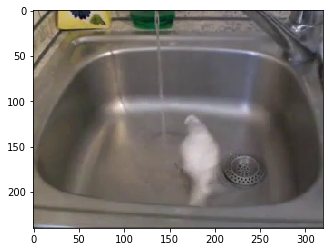

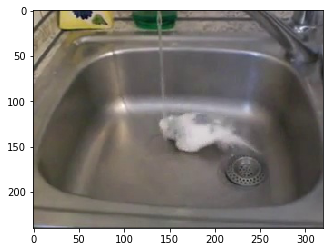

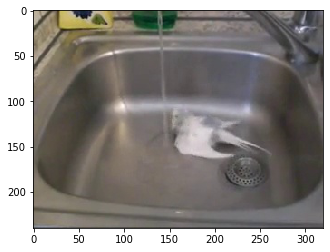

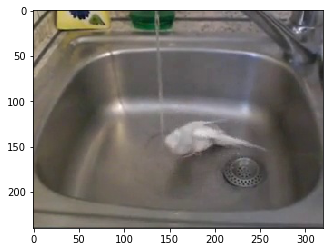

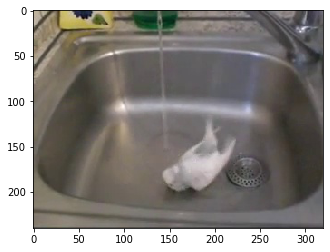

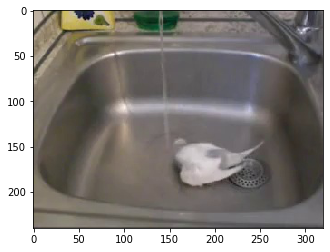

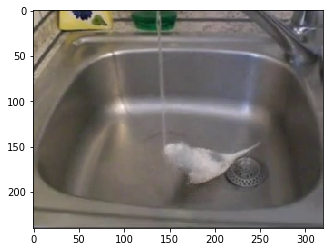

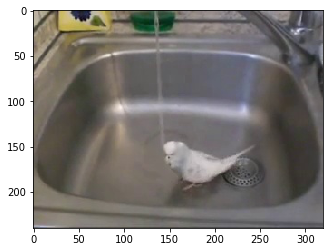

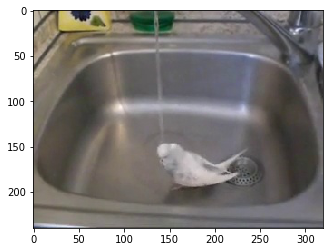

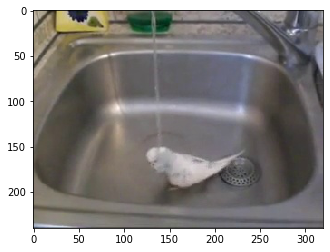

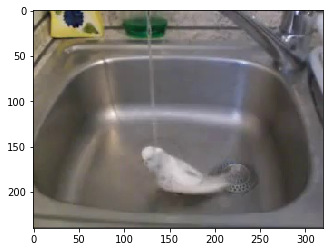

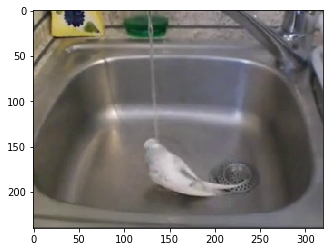

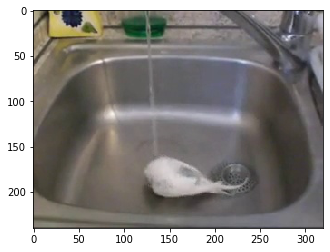

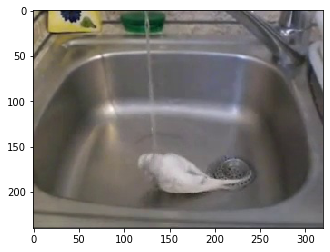

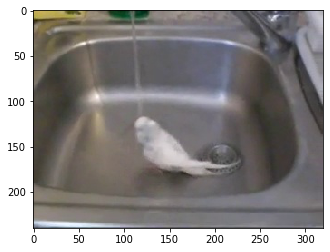

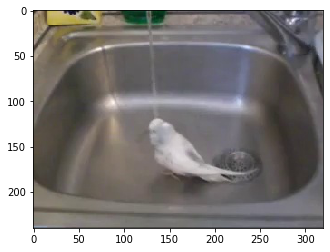

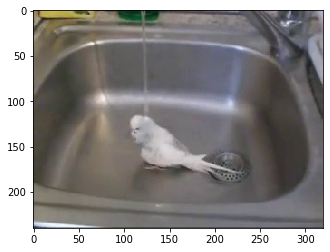

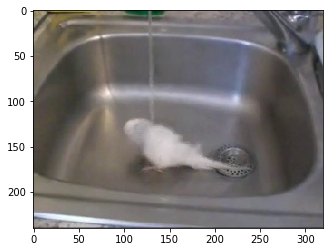

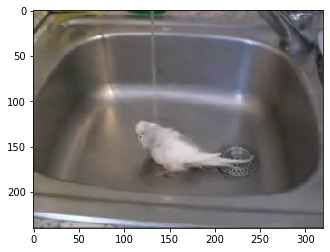

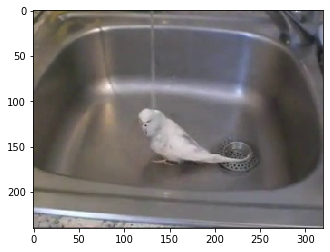

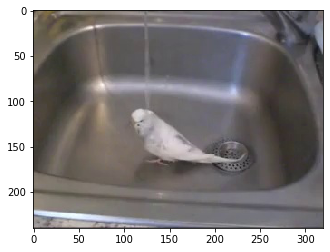

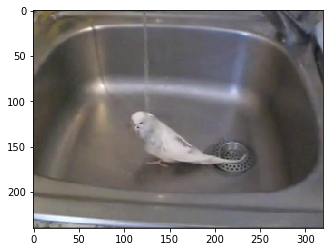

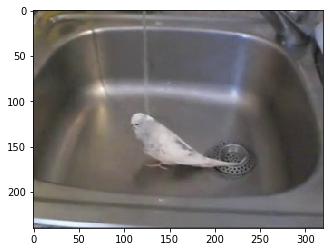

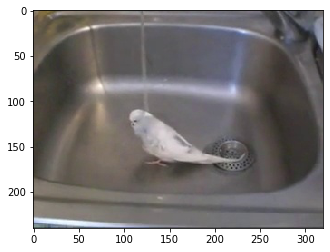

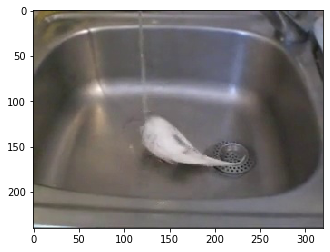

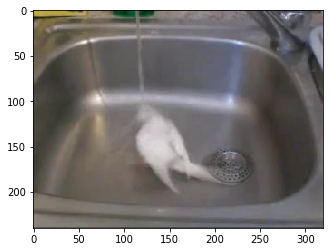

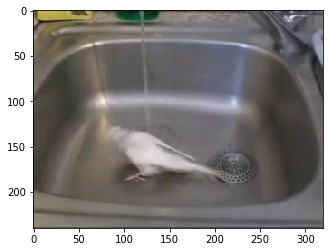

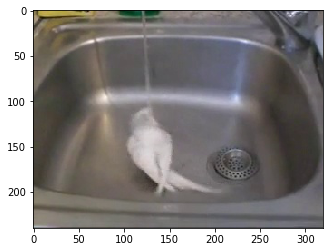

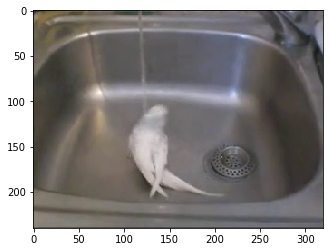

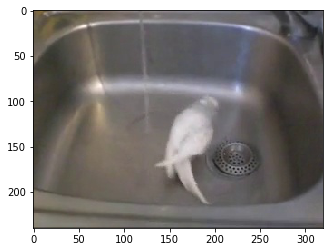

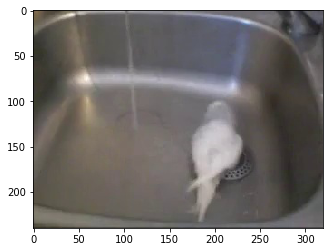

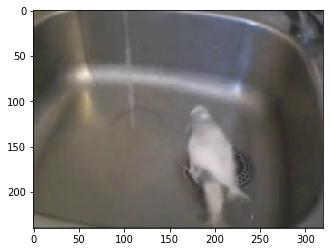

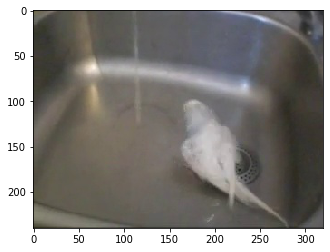

<Figure size 432x288 with 0 Axes>

In [17]:
view_frames('dataset/msvd_videos/frames/mv89psg6zh4_33_46')

In [18]:
#Let's use first 1200 videos for training.
train = data[:1200]
train.shape

(1200, 15, 4096)

In [19]:
#The data contains video extracted features.
#videos_selected contain video names & descriptions contains corresponding caption of those videos.

In [20]:
vocab_size = 1000
embedding_dim = 16
max_length = 20
trunc_type = 'post'
oov_tok = "<oov>"

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(descriptions)

In [22]:
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(descriptions)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

In [23]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    #decoder_dense = Dense(n_output)
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

In [24]:
model, enc, dec = define_models(4096, 1000, 128)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4096)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1000)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 2163200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  578048      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [26]:
x2 = np.hstack([np.zeros((1652, 1)), np.array(padded)])
x2 = x2[:, 1:]

In [27]:
x2.shape

(1652, 20)

In [28]:
#Convert to 1652x20x1
#x2 = x2.reshape(x2.shape + (1, ))
#out = padded.reshape(padded.shape + (1, ))

In [29]:
#Convert to 1652x20x1000
from keras.utils.np_utils import to_categorical   

x2_in = to_categorical(x2, num_classes=1000)
outputs = to_categorical(padded, num_classes=1000)
print(x2_in.shape, outputs.shape)

(1652, 20, 1000) (1652, 20, 1000)


Using TensorFlow backend.


In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([train, x2_in[:1200]], outputs[:1200], epochs = 10)

Train on 1200 samples
Epoch 1/10
1200/1200 [==============================] - 11s 9ms/sample - loss: 3.9280 - accuracy: 0.5221
Epoch 2/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.7529 - accuracy: 0.5344
Epoch 3/10
1200/1200 [==============================] - 1s 973us/sample - loss: 2.6323 - accuracy: 0.5650
Epoch 4/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.5661 - accuracy: 0.5694
Epoch 5/10
1200/1200 [==============================] - 1s 987us/sample - loss: 2.5157 - accuracy: 0.5717
Epoch 6/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.4059 - accuracy: 0.5788
Epoch 7/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.3095 - accuracy: 0.5950
Epoch 8/10
1200/1200 [==============================] - 1s 997us/sample - loss: 2.2140 - accuracy: 0.6047
Epoch 9/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 2.1228 - accuracy: 0.6317
Epoch 10/10
1200/1200 [============